In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy
import torch.nn as nn
import seaborn as sns


In [2]:
# Plots
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        #plt.savefig(filename, bbox_inches='tight')
    plt.show()

    
def lineplot_acc_perturbation(x, y1,y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label='Accuracy - Layer-wise Regularized')
    plt.plot(x, y2, label='Accuracy - Regularized')
    plt.legend(loc='upper right')        
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
def lineplot_l2radius_perturbation(x, y1, y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label="Layer-wise Regularized")
    plt.plot(x, y2, label="Regularized")
    plt.legend(loc='upper left')
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
    


In [3]:
all_base_paths = ["/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_f9c2570b43d17cd3f46b942f31d6fb03", 
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14",
                  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_600547deae5b3d506d5c0befd9134c77"
                  ]

MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()
num_samples = 2560
detector = 'Regular'
c_base=0.3
d_base=0.0
all_eps_list=[[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 
            0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.060, 0.062, 0.064, 0.066, 0.068],
            [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024]]



# Theoretical Epsilon

# PDF

/tmp/ipykernel_3053971/1747271668.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


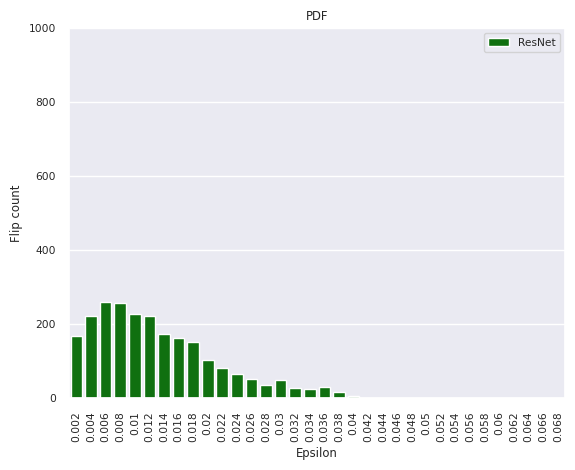

/tmp/ipykernel_3053971/1747271668.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


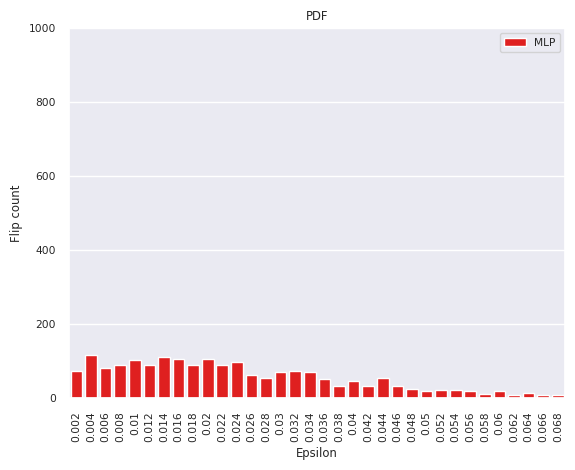

/tmp/ipykernel_3053971/1747271668.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


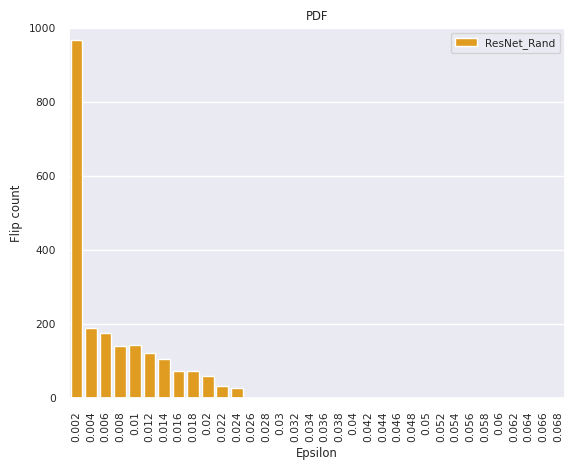

In [10]:

all_freq_lists = []
all_counts = []
for eps_idx, base_path in enumerate(all_base_paths):
    all_flipped_indices = []
    all_emp_eps = []
    all_mse_loss_per_channel = []
    all_mse_loss_per_pixel = []
    all_mse_max_per_pixel = []
    all_mse_loss_per_image = []

    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        base_indices = set(filtered_indices_base)
        common_indices = list(base_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][common_indices]
            images_cw_base[1] = images_cw_base[1][common_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][common_indices]
            images_benign[1] = images_benign[1][common_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1).mean()
        all_mse_loss_per_channel.append(mse_loss_per_channel.item())
        #print(f"L2 per channel : {mse_loss_per_channel}")

        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        all_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        all_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        all_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        
    # Convert flips to counts
    all_emp_eps = np.asarray(all_emp_eps)
    all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel)
    all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel)
    all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel)
    all_mse_loss_per_image = np.asarray(all_mse_loss_per_image)
    # PDF
    old_set = set()
    counts = []
    for lst in all_flipped_indices:
        curr_set = set(lst)
        res = curr_set.difference(old_set)
        counts.append(len(res))
        old_set = curr_set
    
    all_counts.append(counts)
    freq_list = []
    # Convert counts to frequency list
    for i, c in enumerate(counts):
        freq_list.extend([all_eps_list[eps_idx][i] for j in range(c)])
    all_freq_lists.append(freq_list)

# Preprocess for Nones
max_count = max(len(x) for x in all_counts)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
for i in range(len(all_counts)):
    none_arr = [None for k in range(max_count - len(all_counts[i]))]
    all_counts[i].extend(none_arr)


# Theoreical epsilon


# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
arch_rob = {"ResNet" : all_counts[0], "MLP" : all_counts[1],  "ResNet_Rand" : all_counts[2], "Epsilon" : all_eps_list[max_eps_list]}
# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)

sns.set(font_scale=0.7)



ax = sns.barplot(data=df, x='Epsilon', y='ResNet', color='green', label='ResNet')
ax.set_ylim(0, 1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip count')
plt.title("PDF - Theoretical Epsilon")
plt.show()

ax = sns.barplot(data=df, x='Epsilon', y='MLP', color='red', label='MLP')
ax.set_ylim(0,1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Theoretical Epsilon")
ax.set(ylabel='Flip count')
plt.show()


ax = sns.barplot(data=df, x='Epsilon', y='ResNet_Rand', color='orange', label='ResNet_Rand')
ax.set_ylim(0,1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Theoretical Epsilon")
ax.set(ylabel='Flip count')
plt.show()

# CDF

Yoza :  [166, 387, 646, 903, 1129, 1350, 1519, 1679, 1827, 1926, 2006, 2069, 2117, 2152, 2198, 2220, 2243, 2270, 2283, 2287, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Yoza :  [73, 187, 266, 355, 456, 545, 655, 759, 848, 952, 1041, 1136, 1197, 1249, 1317, 1388, 1457, 1508, 1538, 1583, 1613, 1667, 1697, 1720, 1738, 1757, 1777, 1794, 1804, 1821, 1827, 1839, 1845, 1853]
Yoza :  [966, 1155, 1329, 1469, 1610, 1731, 1834, 1906, 1978, 2035, 2067, 2092, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


/tmp/ipykernel_3053971/2211015439.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


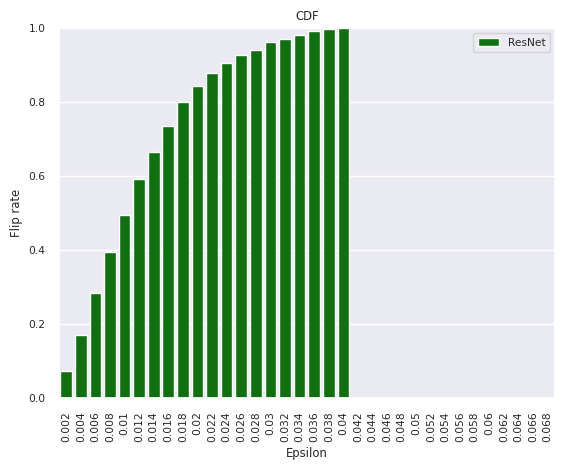

/tmp/ipykernel_3053971/2211015439.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


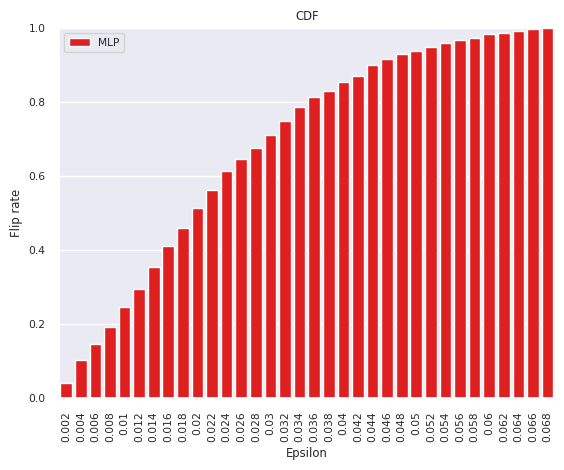

/tmp/ipykernel_3053971/2211015439.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


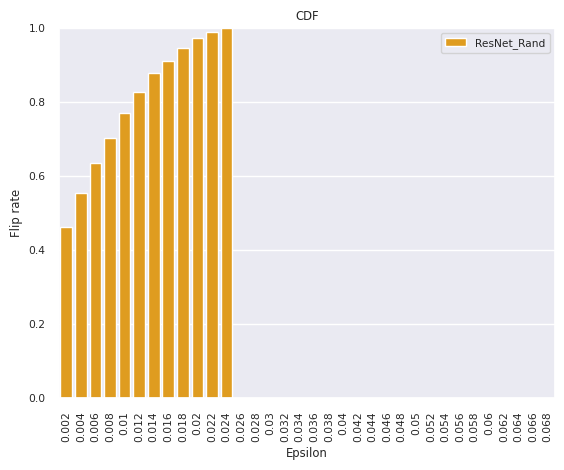

In [13]:

all_freq_lists = []
all_counts = []
for eps_idx, base_path in enumerate(all_base_paths):
    all_flipped_indices = []
    all_emp_eps = []
    all_mse_loss_per_channel = []
    all_mse_loss_per_pixel = []
    all_mse_max_per_pixel = []
    all_mse_loss_per_image = []

    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        base_indices = set(filtered_indices_base)
        common_indices = list(base_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][common_indices]
            images_cw_base[1] = images_cw_base[1][common_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][common_indices]
            images_benign[1] = images_benign[1][common_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1).mean()
        all_mse_loss_per_channel.append(mse_loss_per_channel.item())
        #print(f"L2 per channel : {mse_loss_per_channel}")

        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        all_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        all_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        all_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        
    # Convert flips to counts
    all_emp_eps = np.asarray(all_emp_eps)
    all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel)
    all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel)
    all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel)
    all_mse_loss_per_image = np.asarray(all_mse_loss_per_image)
    
    # CDF
    #old_set = set()
    counts = []
    for lst in all_flipped_indices:
        counts.append(len(lst))
    
    all_counts.append(counts)
    
    """
    freq_list = []
    # Convert counts to frequency list
    for i, c in enumerate(counts):
        freq_list.extend([all_eps_list[eps_idx][i] for j in range(c)])
    all_freq_lists.append(freq_list)
    """

# Preprocess for Nones
max_count = max(len(x) for x in all_counts)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
for i in range(len(all_counts)):
    none_arr = [np.nan for k in range(max_count - len(all_counts[i]))]
    all_counts[i].extend(none_arr)
    all_counts[i] = np.asarray(all_counts[i])
    all_counts[i] = all_counts[i] / np.nanmax(all_counts[i])



max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
arch_rob = {"ResNet" : all_counts[0], "MLP" : all_counts[1], "ResNet_Rand": all_counts[2],  "Epsilon" : all_eps_list[max_eps_list]}
# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)
sns.set(font_scale=0.7)

ax = sns.barplot(data=df, x='Epsilon', y='ResNet', color='green', label='ResNet')
ax.set_ylim(0, 1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("CDF")
ax.set(ylabel='Flip rate')
plt.show()

ax = sns.barplot(data=df, x='Epsilon', y='MLP', color='red', label='MLP')
ax.set_ylim(0,1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip rate')
plt.title("CDF")
plt.show()


ax = sns.barplot(data=df, x='Epsilon', y='ResNet_Rand', color='orange', label='ResNet_Rand')
ax.set_ylim(0,1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip rate')
plt.title("CDF")
plt.show()

# Empirical Epsilon

# PDF

/tmp/ipykernel_3053971/2718649509.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


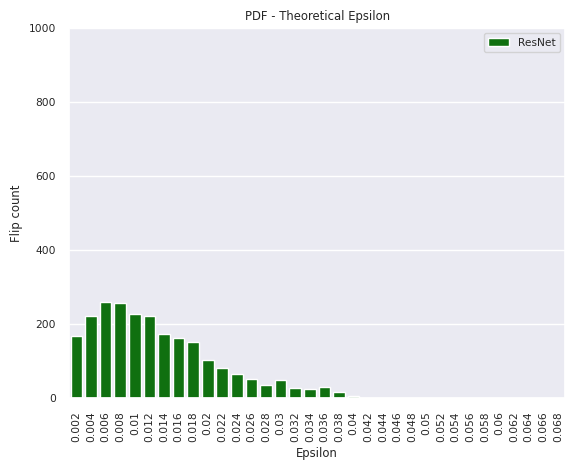

/tmp/ipykernel_3053971/2718649509.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


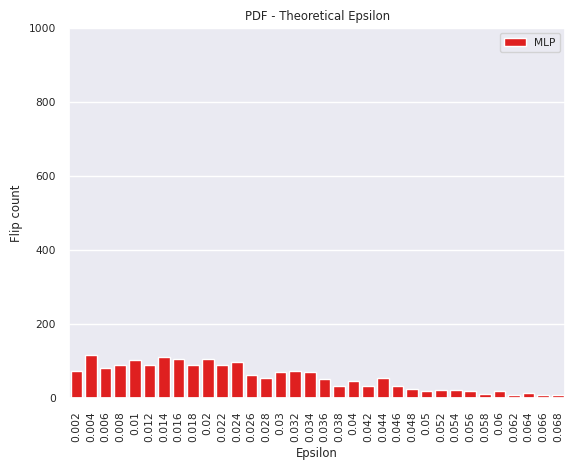

/tmp/ipykernel_3053971/2718649509.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


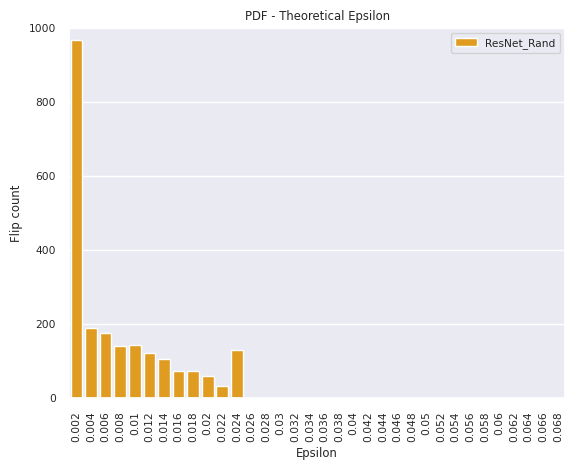

In [14]:

all_freq_lists = []
all_counts = []
for eps_idx, base_path in enumerate(all_base_paths):
    all_flipped_indices = []
    all_emp_eps = []
    all_mse_loss_per_channel = []
    all_mse_loss_per_pixel = []
    all_mse_max_per_pixel = []
    all_mse_loss_per_image = []

    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        base_indices = set(filtered_indices_base)
        common_indices = list(base_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][common_indices]
            images_cw_base[1] = images_cw_base[1][common_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][common_indices]
            images_benign[1] = images_benign[1][common_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1).mean()
        all_mse_loss_per_channel.append(mse_loss_per_channel.item())
        #print(f"L2 per channel : {mse_loss_per_channel}")

        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        all_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        all_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        all_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        
    # Convert flips to counts
    all_emp_eps = np.asarray(all_emp_eps)
    all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel)
    all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel)
    all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel)
    all_mse_loss_per_image = np.asarray(all_mse_loss_per_image)

    
    
    # PDF
    old_set = set()
    counts = []
    for lst in all_flipped_indices:
        curr_set = set(lst)
        res = curr_set.difference(old_set)
        counts.append(len(res))
        old_set = curr_set
    
    all_counts.append(counts)
    freq_list = []
    # Convert counts to frequency list
    for i, c in enumerate(counts):
        freq_list.extend([all_eps_list[eps_idx][i] for j in range(c)])
    all_freq_lists.append(freq_list)


    

# Preprocess for Nones
max_count = max(len(x) for x in all_counts)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
for i in range(len(all_counts)):
    none_arr = [None for k in range(max_count - len(all_counts[i]))]
    all_counts[i].extend(none_arr)


# Theoreical epsilon


# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
arch_rob = {"ResNet" : all_counts[0], "MLP" : all_counts[1],  "ResNet_Rand" : all_counts[2], "Epsilon" : all_eps_list[max_eps_list]}
# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)

sns.set(font_scale=0.7)



ax = sns.barplot(data=df, x='Epsilon', y='ResNet', color='green', label='ResNet')
ax.set_ylim(0, 1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip count')
plt.title("PDF - Theoretical Epsilon")
plt.show()

ax = sns.barplot(data=df, x='Epsilon', y='MLP', color='red', label='MLP')
ax.set_ylim(0,1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Theoretical Epsilon")
ax.set(ylabel='Flip count')
plt.show()


ax = sns.barplot(data=df, x='Epsilon', y='ResNet_Rand', color='orange', label='ResNet_Rand')
ax.set_ylim(0,1000)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("PDF - Theoretical Epsilon")
ax.set(ylabel='Flip count')
plt.show()

In [15]:
df

,ResNet,MLP,ResNet_Rand,Epsilon
0,166.0,73,966.0,0.002
1,221.0,114,189.0,0.004
2,259.0,79,174.0,0.006
3,257.0,89,140.0,0.008
4,227.0,101,141.0,0.010
5,221.0,89,121.0,0.012
6,171.0,110,103.0,0.014
7,161.0,104,73.0,0.016
8,149.0,89,72.0,0.018
9,101.0,104,58.0,0.020


# CDF

Yoza :  [166, 387, 646, 903, 1129, 1350, 1519, 1679, 1827, 1926, 2006, 2069, 2117, 2152, 2198, 2220, 2243, 2270, 2283, 2287, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Yoza :  [73, 187, 266, 355, 456, 545, 655, 759, 848, 952, 1041, 1136, 1197, 1249, 1317, 1388, 1457, 1508, 1538, 1583, 1613, 1667, 1697, 1720, 1738, 1757, 1777, 1794, 1804, 1821, 1827, 1839, 1845, 1853]
Yoza :  [966, 1155, 1329, 1469, 1610, 1731, 1834, 1906, 1978, 2035, 2067, 2092, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


/tmp/ipykernel_3053971/2211015439.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


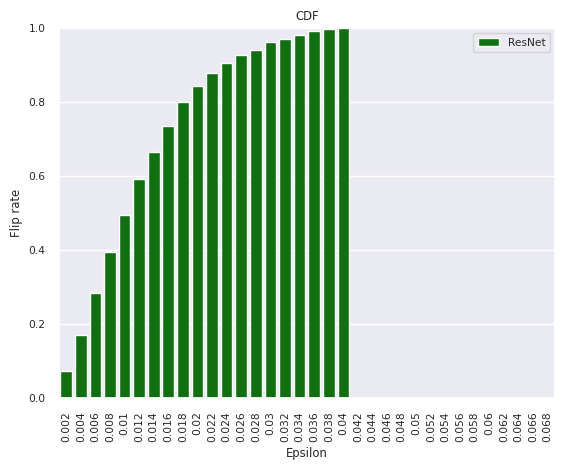

/tmp/ipykernel_3053971/2211015439.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


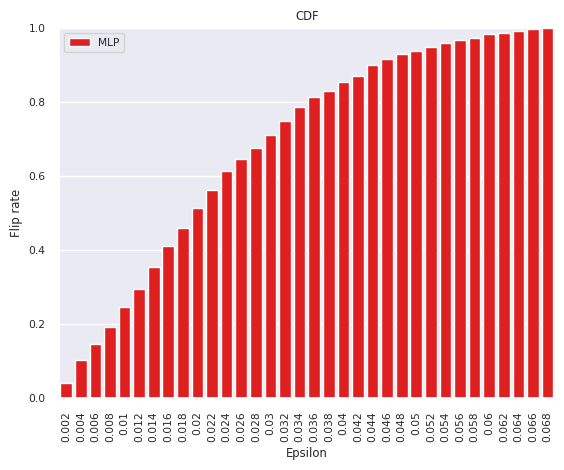

/tmp/ipykernel_3053971/2211015439.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


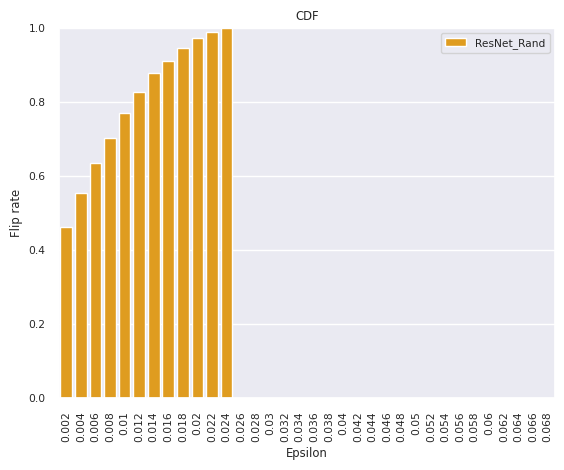

In [ ]:

all_freq_lists = []
all_counts = []
for eps_idx, base_path in enumerate(all_base_paths):
    all_flipped_indices = []
    all_emp_eps = []
    all_mse_loss_per_channel = []
    all_mse_loss_per_pixel = []
    all_mse_max_per_pixel = []
    all_mse_loss_per_image = []

    for eps in (all_eps_list[eps_idx]):
        images_cw_base = f"Adversarial_Datasets/CW_adv_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        images_benign = f"Benign_Datasets/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        predictions_base = f"Predictions/Model/CW_type-adversarial_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pickle"
        filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_{num_samples}_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}_eps-{eps}.pt"
        images_cw_base = os.path.join(base_path, images_cw_base)
        images_benign = os.path.join(base_path, images_benign)
        predictions_base_path = os.path.join(base_path, predictions_base)
        filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)

        # Filter by common indices
        filtered_indices_base = torch.load(filtered_indices_base_path)
        filtered_indices_base = [x.item() for x in filtered_indices_base]
        base_indices = set(filtered_indices_base)
        common_indices = list(base_indices)
        all_flipped_indices.append(filtered_indices_base)

        with open(images_cw_base, 'rb') as in_file:
            images_cw_base = pickle.load(in_file)
            images_cw_base[0] = images_cw_base[0][common_indices]
            images_cw_base[1] = images_cw_base[1][common_indices]
            
        with open(images_benign, 'rb') as in_file:
            images_benign = pickle.load(in_file)
            images_benign[0] = images_benign[0][common_indices]
            images_benign[1] = images_benign[1][common_indices]

        with open(predictions_base_path, 'rb') as in_file:
            predictions = pickle.load(in_file)
            true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
            pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

        mse_loss_per_channel = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_channel = torch.sqrt(mse_loss_per_channel)
        mse_loss_per_channel = mse_loss_per_channel.mean(dim=1).mean()
        all_mse_loss_per_channel.append(mse_loss_per_channel.item())
        #print(f"L2 per channel : {mse_loss_per_channel}")

        mse_loss_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_loss_per_pixel = torch.sqrt(mse_loss_per_pixel.sum(dim=1)).flatten(1).mean(dim=1).mean()
        all_mse_loss_per_pixel.append(mse_loss_per_pixel.item())
        #print(f"L2 per pixel : {mse_loss_per_pixel}")

        mse_max_per_pixel = MSELoss_none(images_cw_base[0], images_benign[0])
        mse_max_per_pixel = torch.sqrt(mse_max_per_pixel.sum(dim=1).flatten(1).max(dim=1)[0]).mean()
        all_mse_max_per_pixel.append(mse_max_per_pixel.item())
        #print(f"L2 max pixel : {mse_max_per_pixel}")

        mse_loss_per_image = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
        mse_loss_per_image = torch.sqrt(mse_loss_per_image.sum(dim=1)).mean()
        all_mse_loss_per_image.append(mse_loss_per_image.item())
        #print(f"L2 per image : {mse_loss_per_image}")
        
    # Convert flips to counts
    all_emp_eps = np.asarray(all_emp_eps)
    all_mse_loss_per_channel = np.asarray(all_mse_loss_per_channel)
    all_mse_loss_per_pixel = np.asarray(all_mse_loss_per_pixel)
    all_mse_max_per_pixel = np.asarray(all_mse_max_per_pixel)
    all_mse_loss_per_image = np.asarray(all_mse_loss_per_image)
    
    # CDF
    #old_set = set()
    counts = []
    for lst in all_flipped_indices:
        counts.append(len(lst))
    
    all_counts.append(counts)
    
    """
    freq_list = []
    # Convert counts to frequency list
    for i, c in enumerate(counts):
        freq_list.extend([all_eps_list[eps_idx][i] for j in range(c)])
    all_freq_lists.append(freq_list)
    """

# Preprocess for Nones
max_count = max(len(x) for x in all_counts)
max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
for i in range(len(all_counts)):
    none_arr = [np.nan for k in range(max_count - len(all_counts[i]))]
    all_counts[i].extend(none_arr)
    all_counts[i] = np.asarray(all_counts[i])
    all_counts[i] = all_counts[i] / np.nanmax(all_counts[i])



max_eps_list = max(enumerate(all_eps_list), key=lambda m : len(m[1]) )[0]
arch_rob = {"ResNet" : all_counts[0], "MLP" : all_counts[1], "ResNet_Rand": all_counts[2],  "Epsilon" : all_eps_list[max_eps_list]}
# Create sample dataset
df = pd.DataFrame.from_dict(arch_rob)
sns.set(font_scale=0.7)

ax = sns.barplot(data=df, x='Epsilon', y='ResNet', color='green', label='ResNet')
ax.set_ylim(0, 1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title("CDF")
ax.set(ylabel='Flip rate')
plt.show()

ax = sns.barplot(data=df, x='Epsilon', y='MLP', color='red', label='MLP')
ax.set_ylim(0,1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip rate')
plt.title("CDF")
plt.show()


ax = sns.barplot(data=df, x='Epsilon', y='ResNet_Rand', color='orange', label='ResNet_Rand')
ax.set_ylim(0,1)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set(ylabel='Flip rate')
plt.title("CDF")
plt.show()

In [ ]:

for idx in range(10):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)


    title_benign = f'GT:{true_labels_base[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}'
    titles = [title_benign, title_base]
    plot_side_by_side(benign, cw_base,  idx, save_path, titles=titles)